In [36]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import yfinance as yf

# Download data
# Download S&P 500 data
data = yf.download("^GSPC", start="1980-01-01", end="2024-09-01")

# Calculate log returns
data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))

# Remove NaN values from log returns
data = data.dropna()


[*********************100%***********************]  1 of 1 completed


VaR: -0.030672158938022387
CVaR: 0.0095270779723858


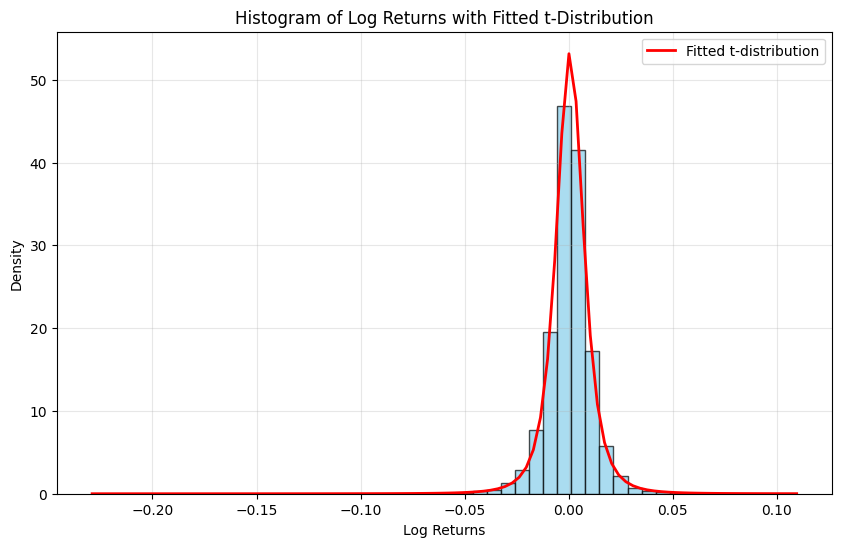

In [42]:
# Fit t-distribution    
params = stats.t.fit(data["log_return"])

# Calculate VaR
VaR = stats.t.ppf(0.01, *params)
print(f'VaR: {VaR}')

# Calculate CVaR
# Calculate CVaR manually
import scipy.integrate as integrate
def integrand(x, df, loc, scale):
    return x * stats.t.pdf(x, df, loc, scale)

CVaR = -integrate.quad(integrand, -np.inf, VaR, args=params)[0] / 0.05
print(f'CVaR: {CVaR}')

import matplotlib.pyplot as plt

# Plot histogram of log returns
plt.figure(figsize=(10, 6))
plt.hist(data["log_return"].dropna(), bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Generate x values for t-distribution plot
x = np.linspace(data["log_return"].min(), data["log_return"].max(), 100)

# Plot fitted t-distribution
plt.plot(x, stats.t.pdf(x, *params), 'r-', lw=2, label='Fitted t-distribution')

plt.title('Histogram of Log Returns with Fitted t-Distribution')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

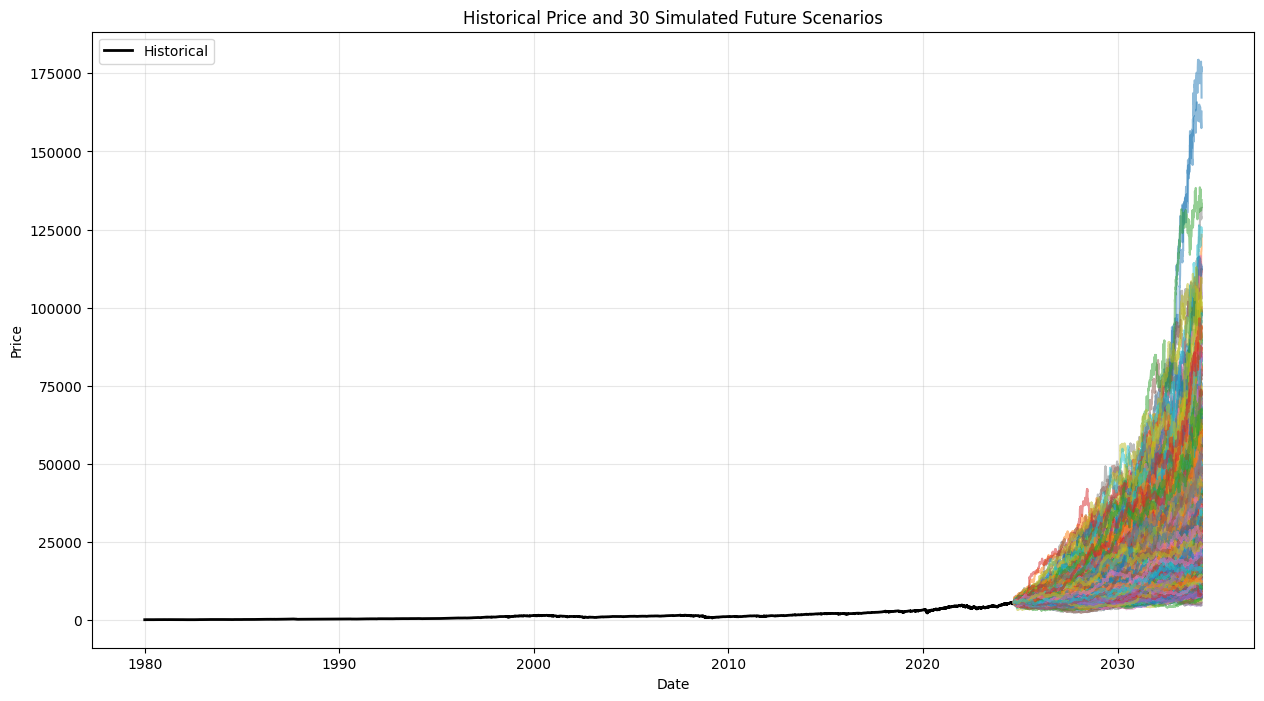

Average simulated return over 2520 trading days: 460.29%
Compound Annual Growth Rate (CAGR): 18.81%
Average simulated return over 2520 trading days: 460.29%

Top 5 portfolio returns:
1. 2860.83%
2. 2781.55%
3. 2280.27%
4. 2235.65%
5. 2083.00%

Bottom 5 portfolio returns:
1. -16.90%
2. -10.44%
3. -1.99%
4. 2.50%
5. 11.30%


In [38]:
# Set random seed for reproducibility
np.random.seed(43)

# Number of simulations and days to simulate
n_simulations = 1000
n_days = 252 * 10  # Approximately 2 years of trading days

# Get the parameters of the fitted t-distribution
df, loc, scale = params

# Generate simulated daily returns
simulated_returns = stats.t.rvs(df, loc, scale, size=(n_simulations, n_days))

# Calculate the last close price from historical data
last_close = data['Close'].iloc[-1]

# Create simulated price paths
simulated_prices = np.zeros((n_simulations, n_days))
simulated_prices[:, 0] = last_close
for i in range(1, n_days):
    simulated_prices[:, i] = simulated_prices[:, i-1] * np.exp(simulated_returns[:, i])

# Prepare historical dates and prices for plotting
historical_dates = data.index
historical_prices = data['Close']

# Create future dates for simulated data
future_dates = pd.date_range(start=historical_dates[-1] + pd.Timedelta(days=1), periods=n_days, freq='B')

# Plot historical and simulated prices
plt.figure(figsize=(15, 8))

# Plot historical prices
plt.plot(historical_dates, historical_prices, label='Historical', color='black', linewidth=2)

# Plot simulated prices
for i in range(n_simulations):
    plt.plot(future_dates, simulated_prices[i], alpha=0.5)

plt.title('Historical Price and 30 Simulated Future Scenarios')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and print the average return across all simulations
# Calculate the average return across all simulations
average_return = (simulated_prices[:, -1] / last_close - 1).mean()

# Calculate the Compound Annual Growth Rate (CAGR)
years = n_days / 252  # Convert trading days to years
cagr = (np.mean(simulated_prices[:, -1] / last_close) ** (1 / years)) - 1

# Print the results
print(f"Average simulated return over {n_days} trading days: {average_return:.2%}")
print(f"Compound Annual Growth Rate (CAGR): {cagr:.2%}")

average_return = (simulated_prices[:, -1] / last_close - 1).mean()
print(f"Average simulated return over {n_days} trading days: {average_return:.2%}")

# Calculate the returns for each simulation
portfolio_returns = (simulated_prices[:, -1] / last_close - 1)

# Sort the returns
sorted_returns = np.sort(portfolio_returns)

# Get the top 5 and bottom 5 returns
top_5_returns = sorted_returns[-5:]
bottom_5_returns = sorted_returns[:5]

# Print the results
print("\nTop 5 portfolio returns:")
for i, ret in enumerate(reversed(top_5_returns), 1):
    print(f"{i}. {ret:.2%}")

print("\nBottom 5 portfolio returns:")
for i, ret in enumerate(bottom_5_returns, 1):
    print(f"{i}. {ret:.2%}")


In [34]:
print(CVaR)
print(params)

0.030109457839874912
(np.float64(2.6519313102825257), np.float64(0.0006456710115859022), np.float64(0.007109275485180769))
